In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def load_single_stock(filepath: str, symbol: str = 'VCB') -> pd.DataFrame:
    df = pd.read_csv(filepath)

    # Filter symbol if needed
    if symbol and 'symbol' in df.columns:
        df = df[df['symbol'] == symbol].copy()

    # Parse date — handles both "05/06/2024 00:00:00" and "2024-06-05" formats
    if df['tradingDate'].str.contains('/').any():
        df['date'] = pd.to_datetime(df['tradingDate'], format='%d/%m/%Y %H:%M:%S')
    else:
        df['date'] = pd.to_datetime(df['tradingDate'])

    df = df.set_index('date').sort_index()

    # Rename columns for convenience
    rename_map = {
        'openPrice': 'open',
        'highestPrice': 'high',
        'lowestPrice': 'low',
        'closePrice': 'close',
        'closePriceAdjusted': 'close_adj',
        'refPrice': 'ref',
        'ceilingPrice': 'ceiling',
        'floorPrice': 'floor',
        'totalMatchVol': 'match_vol',
        'totalMatchVal': 'match_val',
        'totalDealVol': 'deal_vol',
        'totalDealVal': 'deal_val',
        'totalBuyTrade': 'buy_trades',
        'totalSellTrade': 'sell_trades',
        'totalBuyTradeVol': 'buy_trade_vol',
        'totalSellTradeVol': 'sell_trade_vol',
        'foreignBuyVolTotal': 'fgn_buy_vol',
        'foreignSellVolTotal': 'fgn_sell_vol',
        'foreignBuyValTotal': 'fgn_buy_val',
        'foreignSellValTotal': 'fgn_sell_val',
        'netBuySellVol': 'fgn_net_vol',
        'netBuySellVal': 'fgn_net_val',
        'foreignCurrentRoom': 'fgn_room',
        'perPriceChange': 'pct_change_raw',
        'priceChange': 'price_change',
    }
    df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})

    # Derived fields — volume
    df['total_vol'] = df['match_vol'] + df['deal_vol']
    df['total_val'] = df['match_val'] + df['deal_val']

    # Derived fields — returns
    # We compute from close, NOT from refPrice, to get true close-to-close return.
    # perPriceChange uses ref price (which adjusts for corporate actions).
    df['simple_ret'] = df['close'] / df['close'].shift(1) - 1
    df['log_ret'] = np.log(df['close'] / df['close'].shift(1))

    # Derived fields — microstructure
    df['spread_pct'] = (df['high'] - df['low']) / df['close']     # Intraday range as % of close
    df['deal_pct'] = df['deal_vol'] / df['total_vol']             # Block trade share
    df['buy_sell_ratio'] = df['buy_trades'] / df['sell_trades']   # Order count ratio
    df['fgn_pct_vol'] = (df['fgn_buy_vol'] + df['fgn_sell_vol']) / df['match_vol']  # Foreign participation

    return df

In [ ]:
vcb = load_single_stock('/Users/geohanz/Project/random-puzzles/2026/price_ssi_data_vcb.csv')
print(f"Loaded: {vcb.index.min().date()} → {vcb.index.max().date()}, {len(vcb)} trading days")
print(vcb[['close', 'log_ret', 'total_vol', 'fgn_net_val']].tail(5))

Loaded: 2014-01-02 → 2026-02-12, 3024 trading days
            close   log_ret  total_vol   fgn_net_val
date                                                
2026-02-06  65100 -0.049448   24822616 -610245898200
2026-02-09  65000 -0.001537    7331314 -166329892400
2026-02-10  63100 -0.029667   16063903 -224123519700
2026-02-11  64700  0.025040   11139011 -168496193200
2026-02-12  64200 -0.007758    8179530  -92432076000


In [ ]:
def analyze_return_distribution(df):
    """
    Analyze return distribution: simple vs log, skewness, kurtosis, ceiling/floor hits.
    Produces 4-panel chart and summary statistics table.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame from load_single_stock() with columns:
        simple_ret, log_ret, close, ref, ceiling, floor
    """
    diff = df['simple_ret'] - df['log_ret']
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Panel 1: Log return histogram
    axes[0, 0].hist(df['log_ret'].dropna(), bins=80, color='steelblue',
                     edgecolor='white', alpha=0.8)
    axes[0, 0].axvline(x=0, color='red', linestyle='--', alpha=0.5)
    axes[0, 0].set_title('Log Return Distribution')
    axes[0, 0].set_xlabel('Log Return')

    # Panel 2: Scatter simple vs log
    axes[0, 1].scatter(df['simple_ret'], df['log_ret'], alpha=0.3, s=5)
    lim = max(df['simple_ret'].abs().max(), df['log_ret'].abs().max()) * 1.1
    axes[0, 1].plot([-lim, lim], [-lim, lim], 'r--', alpha=0.5, label='y = x')
    axes[0, 1].set_xlabel('Simple Return')
    axes[0, 1].set_ylabel('Log Return')
    axes[0, 1].set_title('Simple vs Log Return')
    axes[0, 1].legend()

    # Panel 3: Divergence increases with magnitude
    axes[1, 0].scatter(df['simple_ret'].abs(), diff.abs(), alpha=0.3, s=5)
    axes[1, 0].axhline(y=0.001, color='red', linestyle='--', label='0.1% threshold')
    axes[1, 0].set_xlabel('|Simple Return|')
    axes[1, 0].set_ylabel('|Simple - Log|')
    axes[1, 0].set_title('Divergence grows with return magnitude')
    axes[1, 0].legend()

    # Panel 4: Return vs ref price (HOSE ±7% band check)
    ret_vs_ref = (df['close'] - df['ref']) / df['ref']
    axes[1, 1].hist(ret_vs_ref.dropna(), bins=80, color='coral', edgecolor='white')
    axes[1, 1].axvline(x=0.07, color='red', linestyle='--', label='Ceiling +7%')
    axes[1, 1].axvline(x=-0.07, color='red', linestyle='--', label='Floor -7%')
    axes[1, 1].set_title('Return vs Ref Price (HOSE ±7% band)')
    axes[1, 1].legend()

    plt.suptitle('Returns Analysis — Distribution & HOSE Limits', fontsize=14)
    plt.tight_layout()
    plt.savefig('return_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Summary statistics
    print("\n" + "="*70)
    print("SUMMARY STATISTICS")
    print("="*70)
    
    for col, name in [('simple_ret', 'Simple Return'), ('log_ret', 'Log Return')]:
        s = df[col].dropna()
        
        print(f"\n{name}:")
        print(f"  Mean (daily):       {s.mean():.6f}  → Annualized: {s.mean() * 252:.4f}")
        print(f"  Std (daily):        {s.std():.6f}  → Annualized: {s.std() * np.sqrt(252):.4f}")
        print(f"  Skewness:           {stats.skew(s):.4f}")
        print(f"  Excess Kurtosis:    {stats.kurtosis(s, fisher=True):.4f}")
        print(f"  Min:                {s.min():.6f}")
        print(f"  Max:                {s.max():.6f}")
        
        jb_stat, jb_pval = stats.jarque_bera(s)
        print(f"  Jarque-Bera p-val:  {jb_pval:.6f}  ", end='')
        if jb_pval < 0.05:
            print("→ Reject normality")
        else:
            print("→ Cannot reject normality")

    # Ceiling/floor hits
    at_ceiling = (df['close'] == df['ceiling']).sum()
    at_floor = (df['close'] == df['floor']).sum()
    
    print(f"\nDays closing at ceiling: {at_ceiling}")
    print(f"Days closing at floor:   {at_floor}")

    # Divergence threshold
    big_diff = diff.abs() > 0.001
    print(f"\nDays where |simple - log| > 0.1%: {big_diff.sum()}")
    if big_diff.any():
        threshold_ret = df.loc[big_diff, 'simple_ret'].abs().min()
        print(f"  → Occurs when |return| >= {threshold_ret:.4f} ({threshold_ret * 100:.2f}%)")

In [ ]:
def detect_corporate_actions(df):
    """
    Detect corporate action days by comparing ref price vs previous close.
    These days can cause "fake jumps" in return series.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame from load_single_stock() with columns:
        close, ref, pct_change_raw, simple_ret
    """
    df = df.copy()
    df['prev_close'] = df['close'].shift(1)
    df['ref_vs_prevclose'] = (df['ref'] - df['prev_close']) / df['prev_close']
    
    # Corporate action days: ref differs from prev close by >1%
    ca_days = df[df['ref_vs_prevclose'].abs() > 0.01]

    print("\n" + "="*70)
    print("CORPORATE ACTION DAYS (|ref - prev_close| > 1%)")
    print("="*70)
    
    if len(ca_days) > 0:
        print(f"Found {len(ca_days)} corporate action day(s):\n")
        
        # Show only first 10 and last 5 if more than 15 days
        if len(ca_days) > 15:
            print("First 10:")
            print(ca_days[['ref', 'prev_close', 'ref_vs_prevclose', 'close']].head(10).to_string())
            print("\n...")
            print(f"\nLast 5:")
            print(ca_days[['ref', 'prev_close', 'ref_vs_prevclose', 'close']].tail(5).to_string())
        else:
            print(ca_days[['ref', 'prev_close', 'ref_vs_prevclose', 'close']].to_string())
        
        print(f"\nTip: Use close_adj (closePriceAdjusted) for continuous return series")
        print(f"     that don't jump on ex-dates.")
    else:
        print("None found in this date range.")

    # Visual comparison
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.plot(df.index, df['pct_change_raw'], label='Return vs Ref Price', alpha=0.7)
    ax.plot(df.index, df['simple_ret'], label='Return vs Prev Close', alpha=0.7)
    ax.set_title('Comparison: Return computed from Ref Price vs Previous Close')
    ax.set_ylabel('Return')
    ax.legend()
    plt.tight_layout()
    plt.savefig('corporate_actions.png', dpi=150)
    plt.show()

    if len(ca_days) > 0:
        print("\n" + "="*70)
        print("INTERPRETATION")
        print("="*70)
        print("Large spikes in 'Return vs Prev Close' on ex-dates are NOT real returns —")
        print("they're mechanical price adjustments due to dividends/rights issues.")
        print("This is why adjusted close (close_adj) matters for backtesting.")

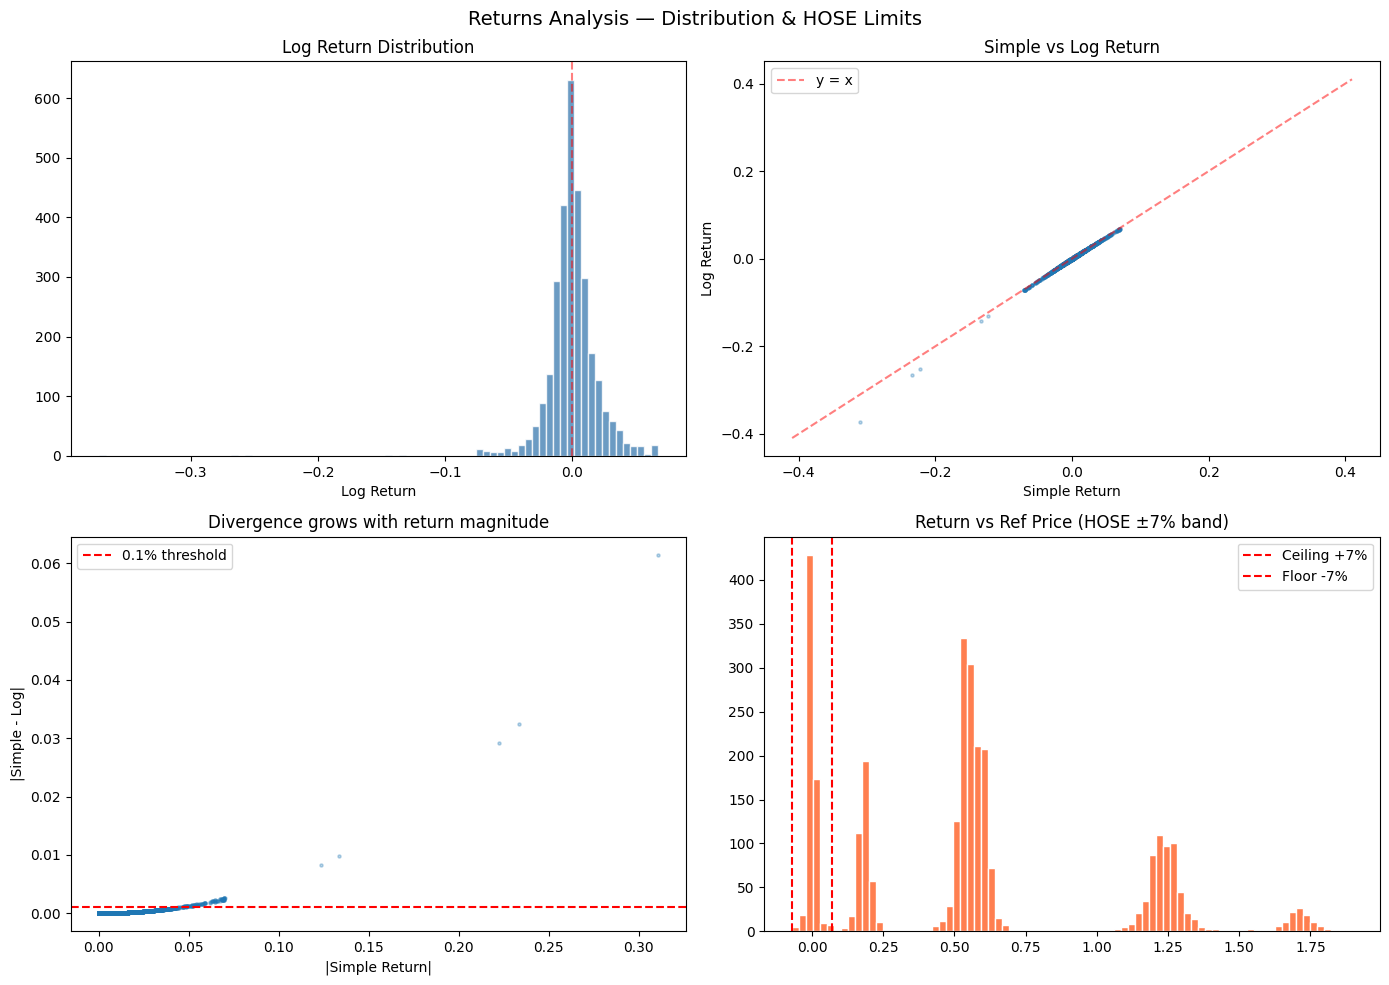


SUMMARY STATISTICS

Simple Return:
  Mean (daily):       0.000495  → Annualized: 0.1247
  Std (daily):        0.019854  → Annualized: 0.3152
  Skewness:           -2.3315
  Excess Kurtosis:    33.6681
  Min:                -0.310950
  Max:                0.069959
  Jarque-Bera p-val:  0.000000  → Reject normality

Log Return:
  Mean (daily):       0.000290  → Annualized: 0.0731
  Std (daily):        0.020464  → Annualized: 0.3249
  Skewness:           -3.5030
  Excess Kurtosis:    55.2651
  Min:                -0.372442
  Max:                0.067620
  Jarque-Bera p-val:  0.000000  → Reject normality

Days closing at ceiling: 14
Days closing at floor:   13

Days where |simple - log| > 0.1%: 109
  → Occurs when |return| >= 0.0443 (4.43%)

CORPORATE ACTION DAYS (|ref - prev_close| > 1%)
Found 2385 corporate action day(s):

First 10:
              ref  prev_close  ref_vs_prevclose  close
date                                                  
2014-01-03   9864     26700.0         -0.63056

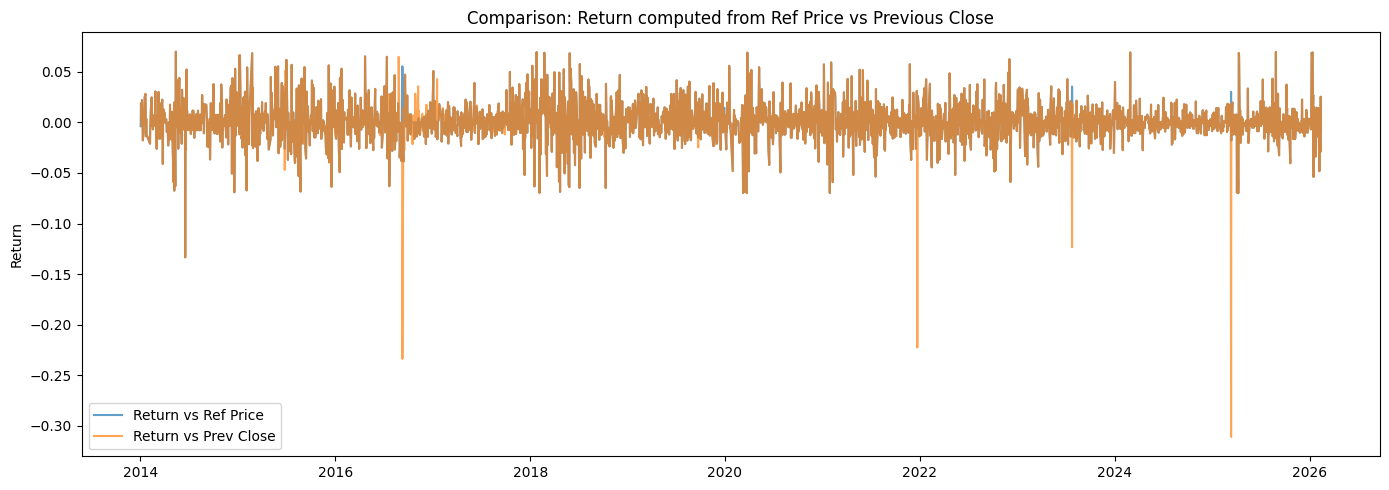


INTERPRETATION
Large spikes in 'Return vs Prev Close' on ex-dates are NOT real returns —
they're mechanical price adjustments due to dividends/rights issues.
This is why adjusted close (close_adj) matters for backtesting.


In [ ]:
analyze_return_distribution(vcb)
detect_corporate_actions(vcb)

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss

def test_stationarity(series, name, significance=0.05):
    """
    Run ADF + KPSS tests, print results, return verdict dict.

    Parameters
    ----------
    series : pd.Series
        Time series to test
    name : str
        Descriptive name for the series
    significance : float
        Significance level (default 0.05)

    Returns
    -------
    dict with keys: name, n_obs, adf_stat, adf_p, kpss_stat, kpss_p, verdict
    """
    # Clean data: remove inf and NaN
    series = series.replace([np.inf, -np.inf], np.nan).dropna()
    
    if len(series) < 20:
        print(f"  {name}: Insufficient data ({len(series)} obs)")
        return None

    # ADF test: H0 = unit root (non-stationary)
    adf_result = adfuller(series, autolag='AIC')
    adf_stat, adf_p = adf_result[0], adf_result[1]
    adf_reject = adf_p < significance

    # KPSS test: H0 = stationary
    kpss_result = kpss(series, regression='c', nlags='auto')
    kpss_stat, kpss_p = kpss_result[0], kpss_result[1]
    kpss_reject = kpss_p < significance

    # Combine both tests to determine verdict
    if adf_reject and not kpss_reject:
        verdict = "Stationary"
    elif not adf_reject and kpss_reject:
        verdict = "Non-stationary"
    elif adf_reject and kpss_reject:
        verdict = "Trend-stationary"
    else:
        verdict = "Inconclusive"

    print(f"\n  {name} (n={len(series)}):")
    print(f"    ADF:  stat={adf_stat:>8.3f}  p={adf_p:.4f}  "
          f"{'REJECT H0 -> stationary' if adf_reject else 'cannot reject -> unit root'}")
    print(f"    KPSS: stat={kpss_stat:>8.3f}  p={kpss_p:.4f}  "
          f"{'REJECT H0 -> non-stationary' if kpss_reject else 'cannot reject -> stationary'}")
    print(f"    --> {verdict}")

    return {
        'name': name, 'n_obs': len(series),
        'adf_stat': adf_stat, 'adf_p': round(adf_p, 4),
        'kpss_stat': kpss_stat, 'kpss_p': round(kpss_p, 4),
        'verdict': verdict
    }

In [ ]:
def analyze_stationarity_comprehensive(df):
    """
    Test stationarity on 13 series derived from stock data.
    
    Tests price, returns, volume, foreign flow, order flow metrics.
    Each series has different expected stationarity properties.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame from load_single_stock() with all derived columns
        
    Returns
    -------
    pd.DataFrame
        Summary table with test results and verdicts
    """
    print("\n" + "="*70)
    print("STATIONARITY TESTS")
    print("="*70)

    test_series = {
        # Group A: Price & Returns
        '1.  Price (close)':                 df['close'],
        '2.  Log Return':                    df['log_ret'],

        # Group B: Volume (raw vs transformed)
        '3.  Volume (total)':                df['total_vol'],
        '4.  Log(Volume)':                   np.log(df['total_vol']),
        '5.  Diff(Log(Volume))':             np.log(df['total_vol']).diff(),
        '6.  Relative Volume (vol/SMA20)':   df['total_vol'] / df['total_vol'].rolling(20).mean(),

        # Group C: Foreign Flow
        '7.  Net Foreign Flow (VND)':        df['fgn_net_val'],
        '8.  Cumsum(Foreign Flow)':          df['fgn_net_val'].cumsum(),

        # Group D: Order Flow & Microstructure
        '9.  Buy/Sell Trade Ratio':          df['buy_sell_ratio'],
        '10. Intraday Spread %':             df['spread_pct'],
        '11. Deal % (block trades)':         df['deal_pct'],
        '12. Foreign Participation %':       df['fgn_pct_vol'],

        # Group E: Volatility Proxy
        '13. |Log Return| (vol proxy)':      df['log_ret'].abs(),
    }

    results = []
    for name, series in test_series.items():
        r = test_stationarity(series, name)
        if r:
            results.append(r)

    # Summary table
    results_df = pd.DataFrame(results)
    print("\n\n" + "="*80)
    print("SUMMARY TABLE")
    print("="*80)
    print(results_df[['name', 'adf_p', 'kpss_p', 'verdict']].to_string(index=False))

    return results_df

In [ ]:
results_df = analyze_stationarity_comprehensive(vcb)
print(results_df)


STATIONARITY TESTS

  1.  Price (close) (n=3024):
    ADF:  stat=  -2.011  p=0.2817  cannot reject -> unit root
    KPSS: stat=   6.400  p=0.0100  REJECT H0 -> non-stationary
    --> Non-stationary

  2.  Log Return (n=3023):
    ADF:  stat= -32.736  p=0.0000  REJECT H0 -> stationary
    KPSS: stat=   0.170  p=0.1000  cannot reject -> stationary
    --> Stationary

  3.  Volume (total) (n=3024):
    ADF:  stat=  -0.506  p=0.8909  cannot reject -> unit root
    KPSS: stat=   2.133  p=0.0100  REJECT H0 -> non-stationary
    --> Non-stationary

  4.  Log(Volume) (n=3022):
    ADF:  stat=  -4.554  p=0.0002  REJECT H0 -> stationary
    KPSS: stat=   3.201  p=0.0100  REJECT H0 -> non-stationary
    --> Trend-stationary

  5.  Diff(Log(Volume)) (n=3020):
    ADF:  stat= -17.219  p=0.0000  REJECT H0 -> stationary
    KPSS: stat=   0.080  p=0.1000  cannot reject -> stationary
    --> Stationary

  6.  Relative Volume (vol/SMA20) (n=3005):
    ADF:  stat= -14.969  p=0.0000  REJECT H0 -> station

<ipython-input-7-6e24b4a48353>:34: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')
<ipython-input-7-6e24b4a48353>:34: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')
<ipython-input-7-6e24b4a48353>:34: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')
<ipython-input-7-6e24b4a48353>:34: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result =


  8.  Cumsum(Foreign Flow) (n=3024):
    ADF:  stat=   5.152  p=1.0000  cannot reject -> unit root
    KPSS: stat=   2.024  p=0.0100  REJECT H0 -> non-stationary
    --> Non-stationary

  9.  Buy/Sell Trade Ratio (n=2825):
    ADF:  stat= -14.802  p=0.0000  REJECT H0 -> stationary
    KPSS: stat=   1.830  p=0.0100  REJECT H0 -> non-stationary
    --> Trend-stationary

  10. Intraday Spread % (n=3024):
    ADF:  stat=  -7.824  p=0.0000  REJECT H0 -> stationary
    KPSS: stat=   2.109  p=0.0100  REJECT H0 -> non-stationary
    --> Trend-stationary

  11. Deal % (block trades) (n=3022):
    ADF:  stat= -10.370  p=0.0000  REJECT H0 -> stationary
    KPSS: stat=   0.464  p=0.0499  REJECT H0 -> non-stationary
    --> Trend-stationary

  12. Foreign Participation % (n=3022):
    ADF:  stat= -13.440  p=0.0000  REJECT H0 -> stationary
    KPSS: stat=   0.372  p=0.0893  cannot reject -> stationary
    --> Stationary

  13. |Log Return| (vol proxy) (n=3023):
    ADF:  stat=  -8.440  p=0.0000  RE

<ipython-input-7-6e24b4a48353>:34: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')
<ipython-input-7-6e24b4a48353>:34: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')
<ipython-input-7-6e24b4a48353>:34: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')


In [ ]:
def prepare_stationary_features(df):
    """
    Transform non-stationary series into stationary ones for modeling.
    
    Parameters
    ----------
    df : pd.DataFrame
        Raw DataFrame from load_single_stock()
    
    Returns
    -------
    pd.DataFrame
        New DataFrame with stationary features ready for modeling
    """
    df_stat = pd.DataFrame(index=df.index)
    
    # Group 1: Returns (already stationary)
    df_stat['log_ret'] = df['log_ret']
    df_stat['simple_ret'] = df['simple_ret']
    
    # Group 2: Volume transformations
    df_stat['vol_diff_log'] = np.log(df['total_vol']).diff()
    df_stat['vol_relative_ma20'] = df['total_vol'] / df['total_vol'].rolling(20).mean()
    df_stat['vol_relative_ma60'] = df['total_vol'] / df['total_vol'].rolling(60).mean()
    
    vol_mean = df['total_vol'].rolling(60).mean()
    vol_std = df['total_vol'].rolling(60).std()
    df_stat['vol_zscore'] = (df['total_vol'] - vol_mean) / vol_std
    
    # Group 3: Foreign flow
    df_stat['fgn_net_val'] = df['fgn_net_val']
    df_stat['fgn_net_vol'] = df['fgn_net_vol']
    df_stat['fgn_net_val_pct'] = df['fgn_net_val'] / df['total_val']
    df_stat['fgn_net_vol_pct'] = df['fgn_net_vol'] / df['total_vol']
    df_stat['fgn_participation_pct'] = df['fgn_pct_vol']
    
    # Group 4: Microstructure (detrend)
    spread_ma = df['spread_pct'].rolling(60).mean()
    df_stat['spread_detrended'] = df['spread_pct'] - spread_ma
    
    deal_ma = df['deal_pct'].rolling(60).mean()
    df_stat['deal_detrended'] = df['deal_pct'] - deal_ma
    
    bs_ratio_ma = df['buy_sell_ratio'].rolling(60).mean()
    df_stat['buy_sell_ratio_detrended'] = df['buy_sell_ratio'] - bs_ratio_ma
    
    # Group 5: Volatility proxy
    df_stat['abs_ret'] = df['log_ret'].abs()
    df_stat['squared_ret'] = df['log_ret'] ** 2
    df_stat['realized_vol_20d'] = df['log_ret'].rolling(20).std()
    df_stat['realized_vol_60d'] = df['log_ret'].rolling(60).std()
    
    # Group 6: Price-based features (using returns, not levels)
    df_stat['dist_from_ma20'] = (df['close'] - df['close'].rolling(20).mean()) / df['close'].rolling(20).mean()
    df_stat['dist_from_ma60'] = (df['close'] - df['close'].rolling(60).mean()) / df['close'].rolling(60).mean()
    
    return df_stat


def visualize_transformation(df, transformations, figsize=(16, 12)):
    """
    Visualize before/after transformation for multiple series.
    Shows original vs transformed series side by side.
    
    Parameters
    ----------
    df : pd.DataFrame
        Raw DataFrame from load_single_stock()
    transformations : list of dict
        Each dict has keys:
        - 'name': Display name
        - 'before': Column name or Series (before transformation)
        - 'after': Column name or Series (after transformation)
        - 'before_label': Label for before plot
        - 'after_label': Label for after plot
    figsize : tuple
        Figure size
    
    Example
    -------
    transformations = [
        {
            'name': 'Price → Log Return',
            'before': df['close'],
            'after': df['log_ret'],
            'before_label': 'Close Price (VND)',
            'after_label': 'Log Return'
        },
        ...
    ]
    """
    n_transforms = len(transformations)
    fig, axes = plt.subplots(n_transforms, 2, figsize=figsize)
    
    # Handle single transformation case
    if n_transforms == 1:
        axes = axes.reshape(1, -1)
    
    for i, trans in enumerate(transformations):
        # Get series
        before = trans['before'] if isinstance(trans['before'], pd.Series) else df[trans['before']]
        after = trans['after'] if isinstance(trans['after'], pd.Series) else df[trans['after']]
        
        # Left panel: Before
        axes[i, 0].plot(before.index, before, linewidth=0.8, alpha=0.8, color='steelblue')
        axes[i, 0].set_title(f"{trans['name']} — BEFORE", fontweight='bold')
        axes[i, 0].set_ylabel(trans['before_label'])
        axes[i, 0].grid(True, alpha=0.3)
        
        # Right panel: After
        axes[i, 1].plot(after.index, after, linewidth=0.8, alpha=0.8, color='coral')
        axes[i, 1].set_title(f"{trans['name']} — AFTER", fontweight='bold')
        axes[i, 1].set_ylabel(trans['after_label'])
        axes[i, 1].axhline(y=0, color='red', linestyle='--', alpha=0.3)
        axes[i, 1].grid(True, alpha=0.3)
    
    plt.suptitle('Data Transformations: Before vs After', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('transformations_before_after.png', dpi=150, bbox_inches='tight')
    plt.show()


def plot_common_transformations(df):
    """
    Plot the most common transformations for stock data.
    Ready-to-use function with predefined transformations.
    
    Parameters
    ----------
    df : pd.DataFrame
        Raw DataFrame from load_single_stock()
    """
    transformations = [
        {
            'name': 'Price → Log Return',
            'before': df['close'],
            'after': df['log_ret'],
            'before_label': 'Close Price (VND)',
            'after_label': 'Log Return'
        },
        {
            'name': 'Volume → Log Diff Volume',
            'before': df['total_vol'],
            'after': np.log(df['total_vol']).diff(),
            'before_label': 'Volume (shares)',
            'after_label': 'Diff(Log(Volume))'
        },
        {
            'name': 'Volume → Relative Volume (vs MA20)',
            'before': df['total_vol'],
            'after': df['total_vol'] / df['total_vol'].rolling(20).mean(),
            'before_label': 'Volume (shares)',
            'after_label': 'Relative Volume'
        },
        {
            'name': 'Foreign Flow → Cumsum (Non-stationary)',
            'before': df['fgn_net_val'],
            'after': df['fgn_net_val'].cumsum(),
            'before_label': 'Daily Net Foreign Flow (VND)',
            'after_label': 'Cumulative Foreign Flow (VND)'
        },
        {
            'name': 'Spread % → Detrended Spread',
            'before': df['spread_pct'],
            'after': df['spread_pct'] - df['spread_pct'].rolling(60).mean(),
            'before_label': 'Intraday Spread %',
            'after_label': 'Detrended Spread %'
        },
        {
            'name': 'Buy/Sell Ratio → Detrended Ratio',
            'before': df['buy_sell_ratio'],
            'after': df['buy_sell_ratio'] - df['buy_sell_ratio'].rolling(60).mean(),
            'before_label': 'Buy/Sell Trade Ratio',
            'after_label': 'Detrended B/S Ratio'
        }
    ]
    
    visualize_transformation(df, transformations, figsize=(16, 14))


def compare_stationarity_before_after(df):
    """
    Run stationarity tests before and after transformation.
    Shows which transformations successfully make series stationary.
    
    Parameters
    ----------
    df : pd.DataFrame
        Raw DataFrame from load_single_stock()
    
    Returns
    -------
    pd.DataFrame
        Comparison table with ADF test results
    """
    test_pairs = [
        ('Price', df['close'], 'Log Return', df['log_ret']),
        ('Volume', df['total_vol'], 'Diff(Log(Vol))', np.log(df['total_vol']).diff()),
        ('Volume', df['total_vol'], 'Relative Vol', df['total_vol'] / df['total_vol'].rolling(20).mean()),
        ('Foreign Flow', df['fgn_net_val'], 'Cumsum Flow', df['fgn_net_val'].cumsum()),
        ('Spread %', df['spread_pct'], 'Detrended Spread', df['spread_pct'] - df['spread_pct'].rolling(60).mean()),
    ]
    
    results = []
    
    for before_name, before_series, after_name, after_series in test_pairs:
        # Test before
        before_clean = before_series.replace([np.inf, -np.inf], np.nan).dropna()
        if len(before_clean) >= 50:
            adf_before = adfuller(before_clean, autolag='AIC')
            before_p = adf_before[1]
            before_stat = '✓ Stationary' if before_p < 0.05 else '✗ Non-stationary'
        else:
            before_p = np.nan
            before_stat = 'N/A'
        
        # Test after
        after_clean = after_series.replace([np.inf, -np.inf], np.nan).dropna()
        if len(after_clean) >= 50:
            adf_after = adfuller(after_clean, autolag='AIC')
            after_p = adf_after[1]
            after_stat = '✓ Stationary' if after_p < 0.05 else '✗ Non-stationary'
        else:
            after_p = np.nan
            after_stat = 'N/A'
        
        results.append({
            'Original': before_name,
            'ADF p-value (before)': round(before_p, 4) if not np.isnan(before_p) else 'N/A',
            'Status (before)': before_stat,
            'Transformed': after_name,
            'ADF p-value (after)': round(after_p, 4) if not np.isnan(after_p) else 'N/A',
            'Status (after)': after_stat
        })
    
    results_df = pd.DataFrame(results)
    
    print("\n" + "="*90)
    print("STATIONARITY COMPARISON: BEFORE vs AFTER TRANSFORMATION")
    print("="*90)
    print(results_df.to_string(index=False))
    print("\n✓ = Stationary (ADF p < 0.05)")
    print("✗ = Non-stationary (ADF p >= 0.05)")
    
    return results_df

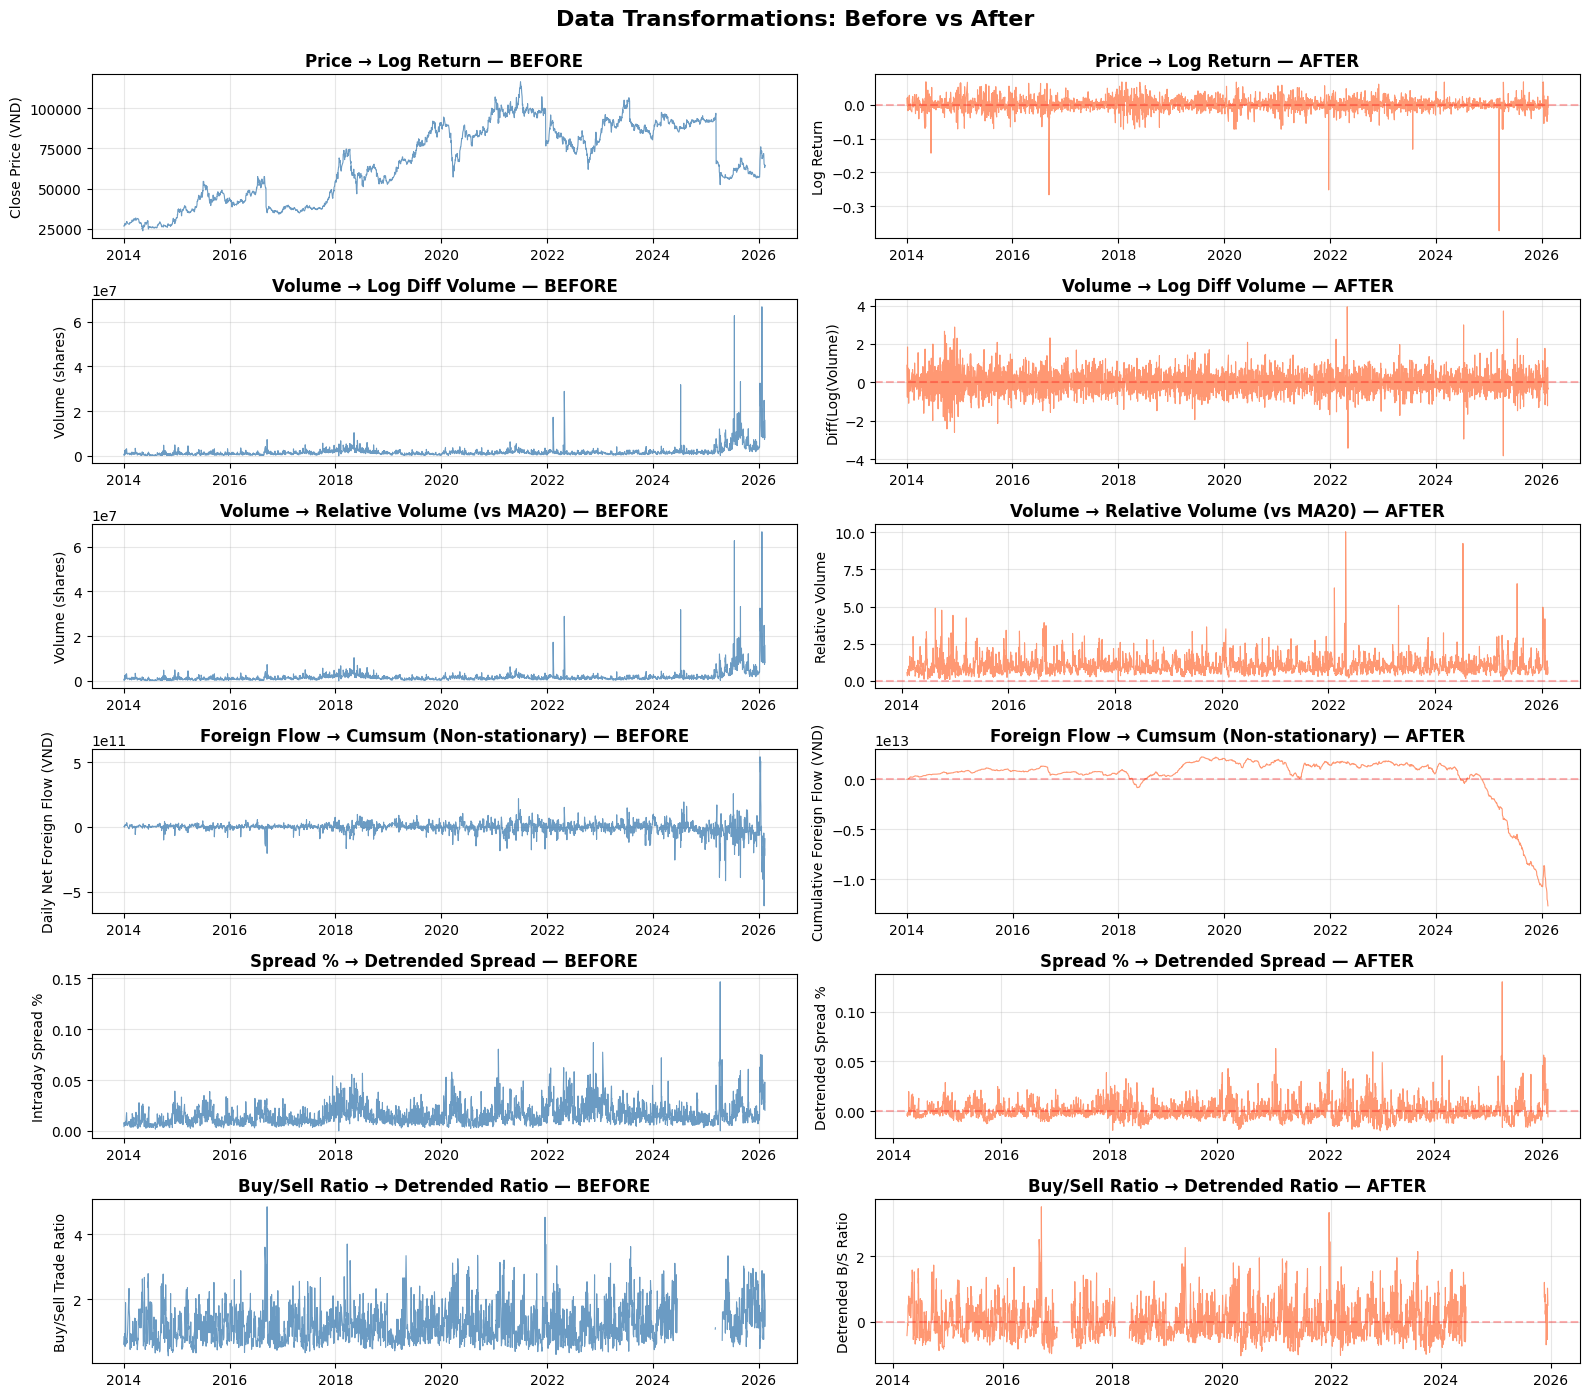

In [ ]:
plot_common_transformations(vcb)

In [ ]:
comparison_df = compare_stationarity_before_after(vcb)


STATIONARITY COMPARISON: BEFORE vs AFTER TRANSFORMATION
    Original  ADF p-value (before)  Status (before)      Transformed  ADF p-value (after)   Status (after)
       Price                0.2817 ✗ Non-stationary       Log Return                  0.0     ✓ Stationary
      Volume                0.8909 ✗ Non-stationary   Diff(Log(Vol))                  0.0     ✓ Stationary
      Volume                0.8909 ✗ Non-stationary     Relative Vol                  0.0     ✓ Stationary
Foreign Flow                0.0000     ✓ Stationary      Cumsum Flow                  1.0 ✗ Non-stationary
    Spread %                0.0000     ✓ Stationary Detrended Spread                  0.0     ✓ Stationary

✓ = Stationary (ADF p < 0.05)
✗ = Non-stationary (ADF p >= 0.05)


In [ ]:
vcb_stationary = prepare_stationary_features(vcb)
print(vcb_stationary.head())

             log_ret  simple_ret  vol_diff_log  vol_relative_ma20  \
date                                                                
2014-01-02       NaN         NaN           NaN                NaN   
2014-01-03  0.018553    0.018727      0.890332                NaN   
2014-01-06 -0.003683   -0.003676     -0.771877                NaN   
2014-01-07  0.021899    0.022140      1.842416                NaN   
2014-01-08  0.014337    0.014440     -0.475726                NaN   

            vol_relative_ma60  vol_zscore  fgn_net_val  fgn_net_vol  \
date                                                                  
2014-01-02                NaN         NaN   2293549000        85910   
2014-01-03                NaN         NaN   1072507000        39650   
2014-01-06                NaN         NaN  -2701408000       -99430   
2014-01-07                NaN         NaN   5864650000       211240   
2014-01-08                NaN         NaN  12576679000       451900   

            fgn_ne

In [ ]:
def analyze_rolling_volatility(df, windows=[5, 10, 20, 60, 120]):
    """
    Compare rolling volatility across multiple window sizes.
    Shows which window responds fastest to volatility shocks.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame from load_single_stock()
    windows : list of int
        List of window sizes to compare (default: [5, 10, 20, 60, 120])
    """
    fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

    # Top panel: price for context
    axes[0].plot(df.index, df['close'] / 1000, color='black', linewidth=1)
    axes[0].set_title('Close Price (thousand VND)')
    axes[0].set_ylabel('Price (k VND)')

    # Bottom panel: rolling volatility for each window
    colors = ['#e74c3c', '#e67e22', '#2ecc71', '#3498db', '#9b59b6']

    for w, c in zip(windows, colors):
        # Annualized volatility = daily_std * sqrt(252)
        rvol = df['log_ret'].rolling(w).std() * np.sqrt(252)
        axes[1].plot(df.index, rvol, color=c, label=f'{w}d', alpha=0.8)

    axes[1].set_title('Rolling Annualized Volatility — Multiple Windows')
    axes[1].set_ylabel('Volatility (annualized)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('rolling_volatility.png', dpi=150)
    plt.show()

    # Quantify response speed: find peak volatility date for each window
    print("\n" + "="*70)
    print("PEAK VOLATILITY BY WINDOW SIZE")
    print("="*70)
    for w in windows:
        rvol = df['log_ret'].rolling(w).std() * np.sqrt(252)
        peak_date = rvol.idxmax()
        print(f"  {w:>3d}d window: peak on {peak_date.date()}, vol = {rvol.max():.2%}")

    print("\n→ Shorter windows peak earlier (detect shocks faster)")
    print("→ Longer windows peak later (include more pre-shock calm data)")

In [ ]:
def analyze_volume_microstructure(df):
    """
    Analyze volume microstructure using VN-specific data.
    
    Shows:
    1. Relative volume with spike detection
    2. Rolling block trade share (deal volume %)
    3. Buy vs sell order count (order flow pressure)
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame from load_single_stock()
    """
    fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

    # Panel 1: Relative volume with spike detection
    rel_vol = df['total_vol'] / df['total_vol'].rolling(20).mean()
    bar_colors = np.where(rel_vol > 2, 'red', 'steelblue')
    
    axes[0].bar(df.index, rel_vol, color=bar_colors, width=1, alpha=0.7)
    axes[0].axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Normal (1.0x)')
    axes[0].axhline(y=2.0, color='red', linestyle='--', alpha=0.5, label='Spike (2.0x)')
    axes[0].set_title('Relative Volume (volume / SMA20)')
    axes[0].set_ylabel('Multiple')
    axes[0].legend()

    # Panel 2: Rolling block trade share
    rolling_deal_pct = df['deal_vol'].rolling(20).sum() / df['total_vol'].rolling(20).sum()
    axes[1].plot(df.index, rolling_deal_pct * 100, color='darkorange', linewidth=1.5)
    axes[1].set_title('Rolling 20d Block Trade Share (deal vol / total vol)')
    axes[1].set_ylabel('%')

    # Panel 3: Buy vs sell order count
    rolling_buy = df['buy_trades'].rolling(10).mean()
    rolling_sell = df['sell_trades'].rolling(10).mean()
    
    axes[2].plot(df.index, rolling_buy, color='green', label='Buy orders (SMA10)')
    axes[2].plot(df.index, rolling_sell, color='red', label='Sell orders (SMA10)')
    axes[2].fill_between(df.index, rolling_buy, rolling_sell,
                         where=rolling_buy > rolling_sell, alpha=0.2, color='green')
    axes[2].fill_between(df.index, rolling_buy, rolling_sell,
                         where=rolling_buy < rolling_sell, alpha=0.2, color='red')
    axes[2].set_title('Rolling 10d: Buy vs Sell Order Count')
    axes[2].set_ylabel('# Orders')
    axes[2].legend()

    plt.suptitle('Volume Microstructure Analysis', fontsize=14)
    plt.tight_layout()
    plt.savefig('volume_microstructure.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Volume spike analysis
    spike_mask = rel_vol > 2
    n_spikes = spike_mask.sum()
    
    if n_spikes > 0:
        print("\n" + "="*70)
        print(f"VOLUME SPIKE ANALYSIS (>2x normal)")
        print("="*70)
        print(f"Total spike days: {n_spikes}")
        print(f"Avg return on spike days:      {df.loc[spike_mask, 'log_ret'].mean():.4f}")
        print(f"Avg return on normal days:     {df.loc[~spike_mask, 'log_ret'].mean():.4f}")

        next_ret = df['log_ret'].shift(-1)
        print(f"Avg return DAY AFTER spike:    {next_ret[spike_mask].mean():.4f}")
        print(f"Avg |return| on spike days:    {df.loc[spike_mask, 'log_ret'].abs().mean():.4f}")
        print(f"Avg |return| on normal days:   {df.loc[~spike_mask, 'log_ret'].abs().mean():.4f}")
        print("\n→ Volume spikes = large moves, but direction varies")

In [ ]:
def analyze_foreign_flow(df):
    """
    Analyze foreign investor flow patterns and predictive power.
    
    Shows:
    1. Price context
    2. Daily net foreign flow (with SMA20)
    3. Cumulative flow (trend indicator)
    4. Foreign room remaining
    5. Rolling correlation: flow(t) vs return(t+1)
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame from load_single_stock()
    """
    fig, axes = plt.subplots(4, 1, figsize=(14, 14), sharex=True)

    # Panel 1: Price
    axes[0].plot(df.index, df['close'] / 1000, color='black', linewidth=1)
    axes[0].set_title('Price (k VND)')
    axes[0].set_ylabel('k VND')

    # Panel 2: Daily net foreign flow
    bar_colors = np.where(df['fgn_net_val'] > 0, 'green', 'red')
    axes[1].bar(df.index, df['fgn_net_val'] / 1e9, color=bar_colors, width=1, alpha=0.6)
    fgn_sma20 = df['fgn_net_val'].rolling(20).mean() / 1e9
    axes[1].plot(df.index, fgn_sma20, color='blue', linewidth=2, label='SMA20')
    axes[1].axhline(y=0, color='black', linewidth=0.5)
    axes[1].set_title('Daily Net Foreign Flow (bn VND)')
    axes[1].set_ylabel('Bn VND')
    axes[1].legend()

    # Panel 3: Cumulative foreign flow
    cum_fgn = df['fgn_net_val'].cumsum() / 1e9
    axes[2].plot(df.index, cum_fgn, color='darkblue', linewidth=1.5)
    axes[2].fill_between(df.index, 0, cum_fgn, where=cum_fgn > 0, alpha=0.2, color='green')
    axes[2].fill_between(df.index, 0, cum_fgn, where=cum_fgn < 0, alpha=0.2, color='red')
    axes[2].set_title('Cumulative Net Foreign Flow (bn VND)')
    axes[2].set_ylabel('Bn VND (cumulative)')

    # Panel 4: Foreign room
    if 'fgn_room' in df.columns and df['fgn_room'].notna().any():
        axes[3].plot(df.index, df['fgn_room'] / 1e6, color='purple', linewidth=1)
        axes[3].set_title('Foreign Room Remaining (million shares)')
        axes[3].set_ylabel('M shares')
    else:
        axes[3].text(0.5, 0.5, 'No fgn_room data', transform=axes[3].transAxes,
                     ha='center', va='center', fontsize=14, color='gray')

    plt.suptitle('Foreign Flow Deep Dive', fontsize=14)
    plt.tight_layout()
    plt.savefig('foreign_flow.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Predictive power test
    fwd_ret = df['log_ret'].shift(-1)  # tomorrow's return
    rolling_corr = df['fgn_net_val'].rolling(60).corr(fwd_ret)

    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(df.index, rolling_corr, color='darkgreen', linewidth=1)
    ax.axhline(y=0, color='red', linestyle='--')
    ax.fill_between(df.index, 0, rolling_corr, where=rolling_corr > 0, alpha=0.2, color='green')
    ax.fill_between(df.index, 0, rolling_corr, where=rolling_corr < 0, alpha=0.2, color='red')
    ax.set_title('Rolling 60d Correlation: Net Foreign Flow(t) vs Return(t+1)')
    ax.set_ylabel('Correlation')
    plt.tight_layout()
    plt.savefig('flow_predictability.png', dpi=150)
    plt.show()

    mean_corr = rolling_corr.mean()
    print("\n" + "="*70)
    print("FOREIGN FLOW PREDICTIVE POWER")
    print("="*70)
    print(f"Mean rolling correlation (flow → next-day return): {mean_corr:.4f}")
    print(f"Median: {rolling_corr.median():.4f}")
    print(f"% of days with positive correlation: {(rolling_corr > 0).mean():.1%}")
    print(f"\nInterpretation:")
    print(f"  → Positive corr = foreign flow has predictive power (buy today → price up tomorrow)")
    print(f"  → Negative corr = foreign flow is contrarian indicator")
    print(f"  → Near zero = no relationship")

In [ ]:
def create_comprehensive_dashboard(df):
    """
    Create 6-panel comprehensive dashboard combining all rolling analyses.
    
    Panels:
    1. Price
    2. Rolling 20d volatility
    3. Rolling 60d Sharpe ratio
    4. Relative volume (with spike highlighting)
    5. Net foreign flow (rolling 20d mean)
    6. Buy/sell trade ratio (rolling 10d)
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame from load_single_stock()
    """
    fig, axes = plt.subplots(6, 1, figsize=(16, 22), sharex=True)
    ret = df['log_ret']

    # Panel 1: Price
    axes[0].plot(df.index, df['close'] / 1000, 'k-', linewidth=1)
    axes[0].set_ylabel('k VND')
    axes[0].set_title('(1) Close Price')

    # Panel 2: Rolling Volatility
    rvol = ret.rolling(20).std() * np.sqrt(252)
    axes[1].plot(df.index, rvol, color='orange', linewidth=1)
    p90 = rvol.quantile(0.9)
    axes[1].axhline(y=p90, color='red', linestyle=':', alpha=0.5, label=f'P90 = {p90:.2%}')
    axes[1].set_ylabel('Ann. Vol')
    axes[1].set_title('(2) Rolling 20d Annualized Volatility')
    axes[1].legend()

    # Panel 3: Rolling Sharpe Ratio
    rsharpe = (ret.rolling(60).mean() / ret.rolling(60).std()) * np.sqrt(252)
    axes[2].plot(df.index, rsharpe, color='green', linewidth=1)
    axes[2].axhline(y=0, color='red', linestyle='--')
    axes[2].fill_between(df.index, 0, rsharpe, where=rsharpe < 0, alpha=0.2, color='red')
    axes[2].fill_between(df.index, 0, rsharpe, where=rsharpe > 0, alpha=0.1, color='green')
    axes[2].set_ylabel('Sharpe')
    axes[2].set_title('(3) Rolling 60d Sharpe Ratio')

    # Panel 4: Relative Volume
    rel_vol = df['total_vol'] / df['total_vol'].rolling(20).mean()
    bar_colors = np.where(rel_vol > 2, 'red', 'steelblue')
    axes[3].bar(df.index, rel_vol, color=bar_colors, width=1, alpha=0.6)
    axes[3].axhline(y=1, color='black', linestyle='--', alpha=0.3)
    axes[3].axhline(y=2, color='red', linestyle=':', alpha=0.5)
    axes[3].set_ylabel('Multiple')
    axes[3].set_title('(4) Relative Volume (vol / SMA20)')

    # Panel 5: Foreign Flow
    fgn_sma = df['fgn_net_val'].rolling(20).mean() / 1e9
    axes[4].plot(df.index, fgn_sma, color='darkblue', linewidth=1)
    axes[4].axhline(y=0, color='red', linestyle='--')
    axes[4].fill_between(df.index, 0, fgn_sma, where=fgn_sma > 0, alpha=0.2, color='green')
    axes[4].fill_between(df.index, 0, fgn_sma, where=fgn_sma < 0, alpha=0.2, color='red')
    axes[4].set_ylabel('Bn VND')
    axes[4].set_title('(5) Net Foreign Flow — SMA 20d (bn VND)')

    # Panel 6: Buy/Sell Ratio
    bs_ratio = df['buy_trades'].rolling(10).mean() / df['sell_trades'].rolling(10).mean()
    axes[5].plot(df.index, bs_ratio, color='purple', linewidth=1)
    axes[5].axhline(y=1, color='red', linestyle='--')
    axes[5].fill_between(df.index, 1, bs_ratio, where=bs_ratio > 1, alpha=0.15, color='green')
    axes[5].fill_between(df.index, 1, bs_ratio, where=bs_ratio < 1, alpha=0.15, color='red')
    axes[5].set_ylabel('Ratio')
    axes[5].set_title('(6) Buy / Sell Order Count Ratio — SMA 10d')

    plt.suptitle('Comprehensive Rolling Analysis Dashboard', fontsize=16, y=1.005)
    plt.tight_layout()
    plt.savefig('comprehensive_dashboard.png', dpi=150, bbox_inches='tight')
    plt.show()

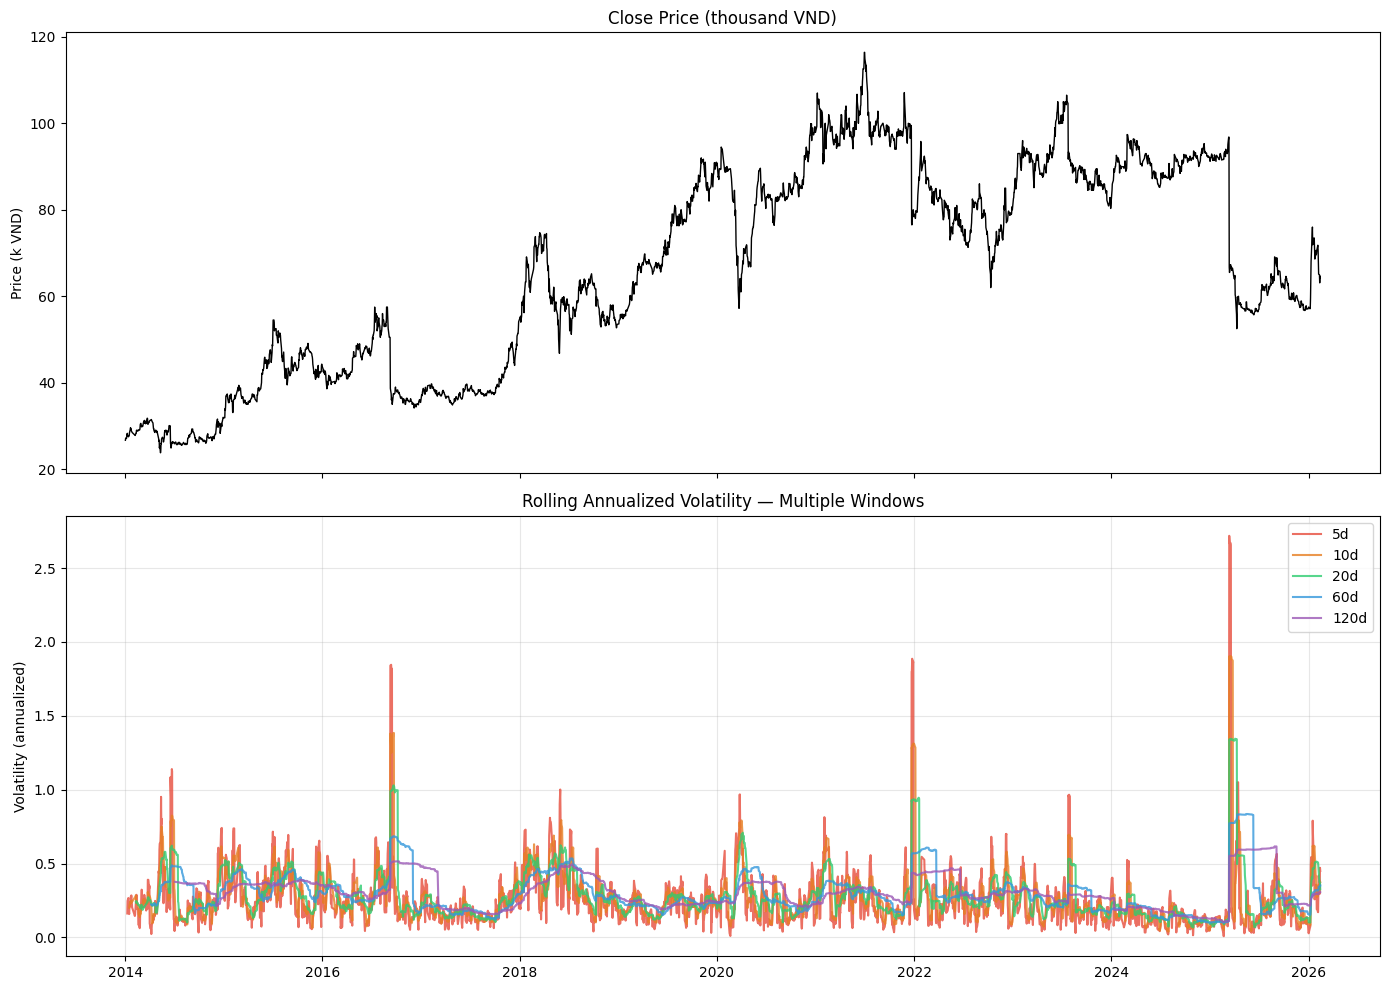


PEAK VOLATILITY BY WINDOW SIZE
    5d window: peak on 2025-03-12, vol = 271.78%
   10d window: peak on 2025-03-17, vol = 190.38%
   20d window: peak on 2025-04-03, vol = 134.49%
   60d window: peak on 2025-05-16, vol = 83.52%
  120d window: peak on 2025-08-27, vol = 61.63%

→ Shorter windows peak earlier (detect shocks faster)
→ Longer windows peak later (include more pre-shock calm data)


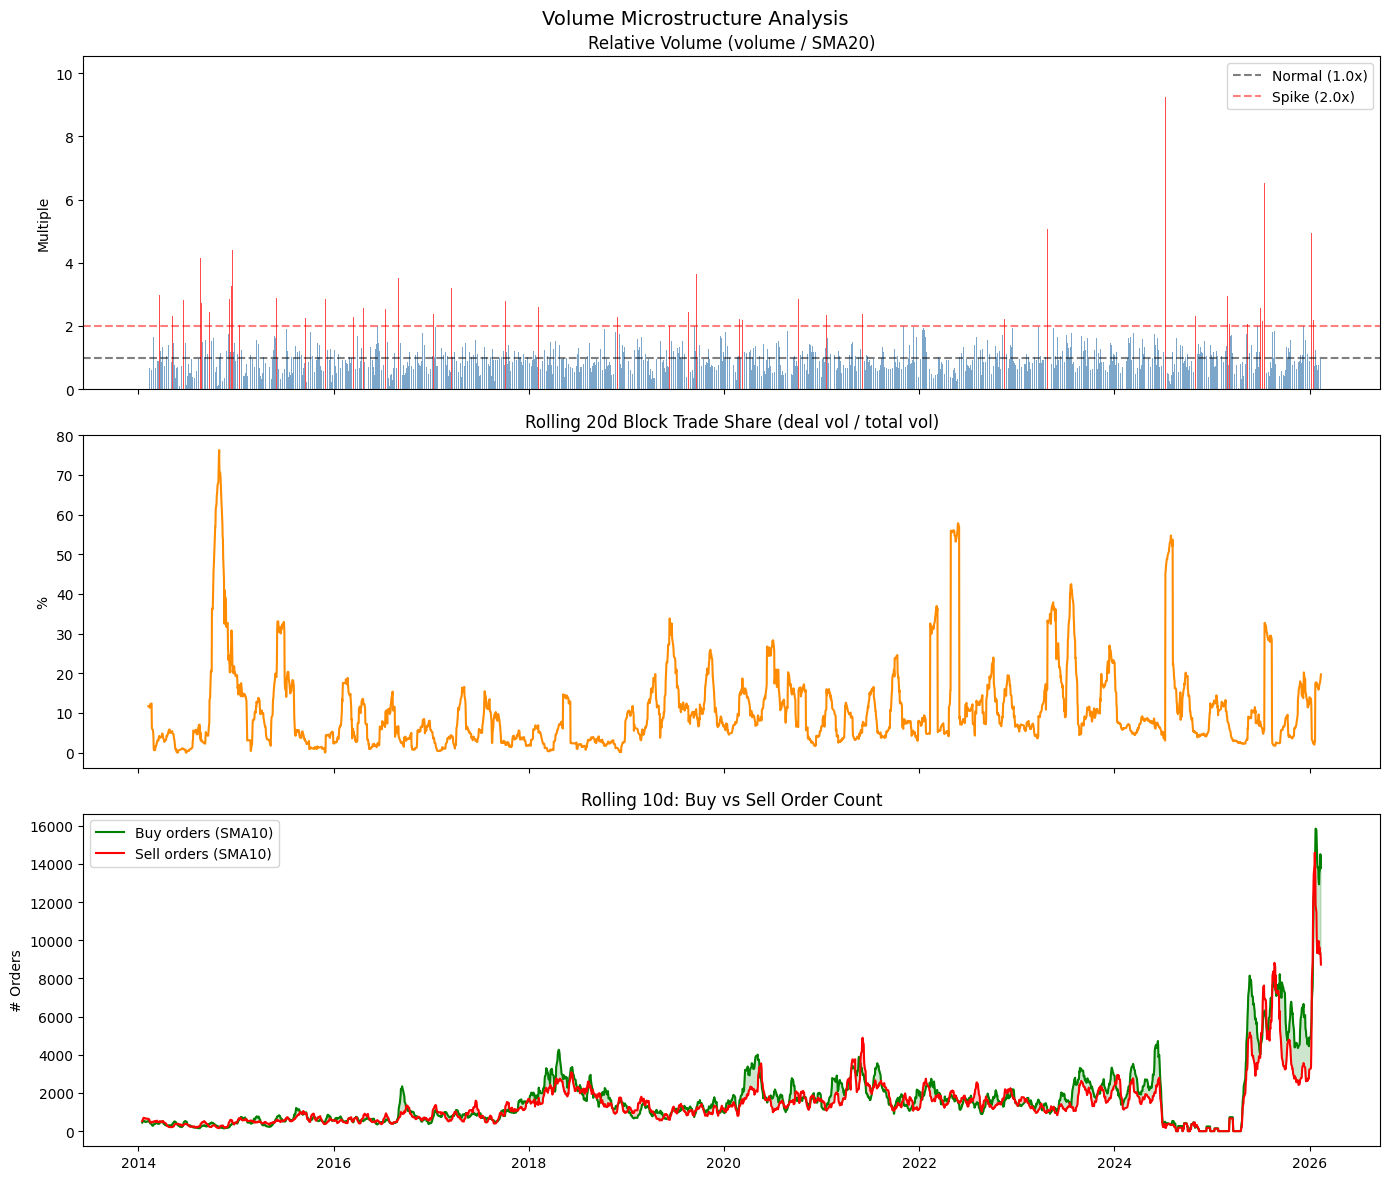


VOLUME SPIKE ANALYSIS (>2x normal)
Total spike days: 161
Avg return on spike days:      0.0010
Avg return on normal days:     0.0002
Avg return DAY AFTER spike:    0.0014
Avg |return| on spike days:    0.0302
Avg |return| on normal days:   0.0116

→ Volume spikes = large moves, but direction varies


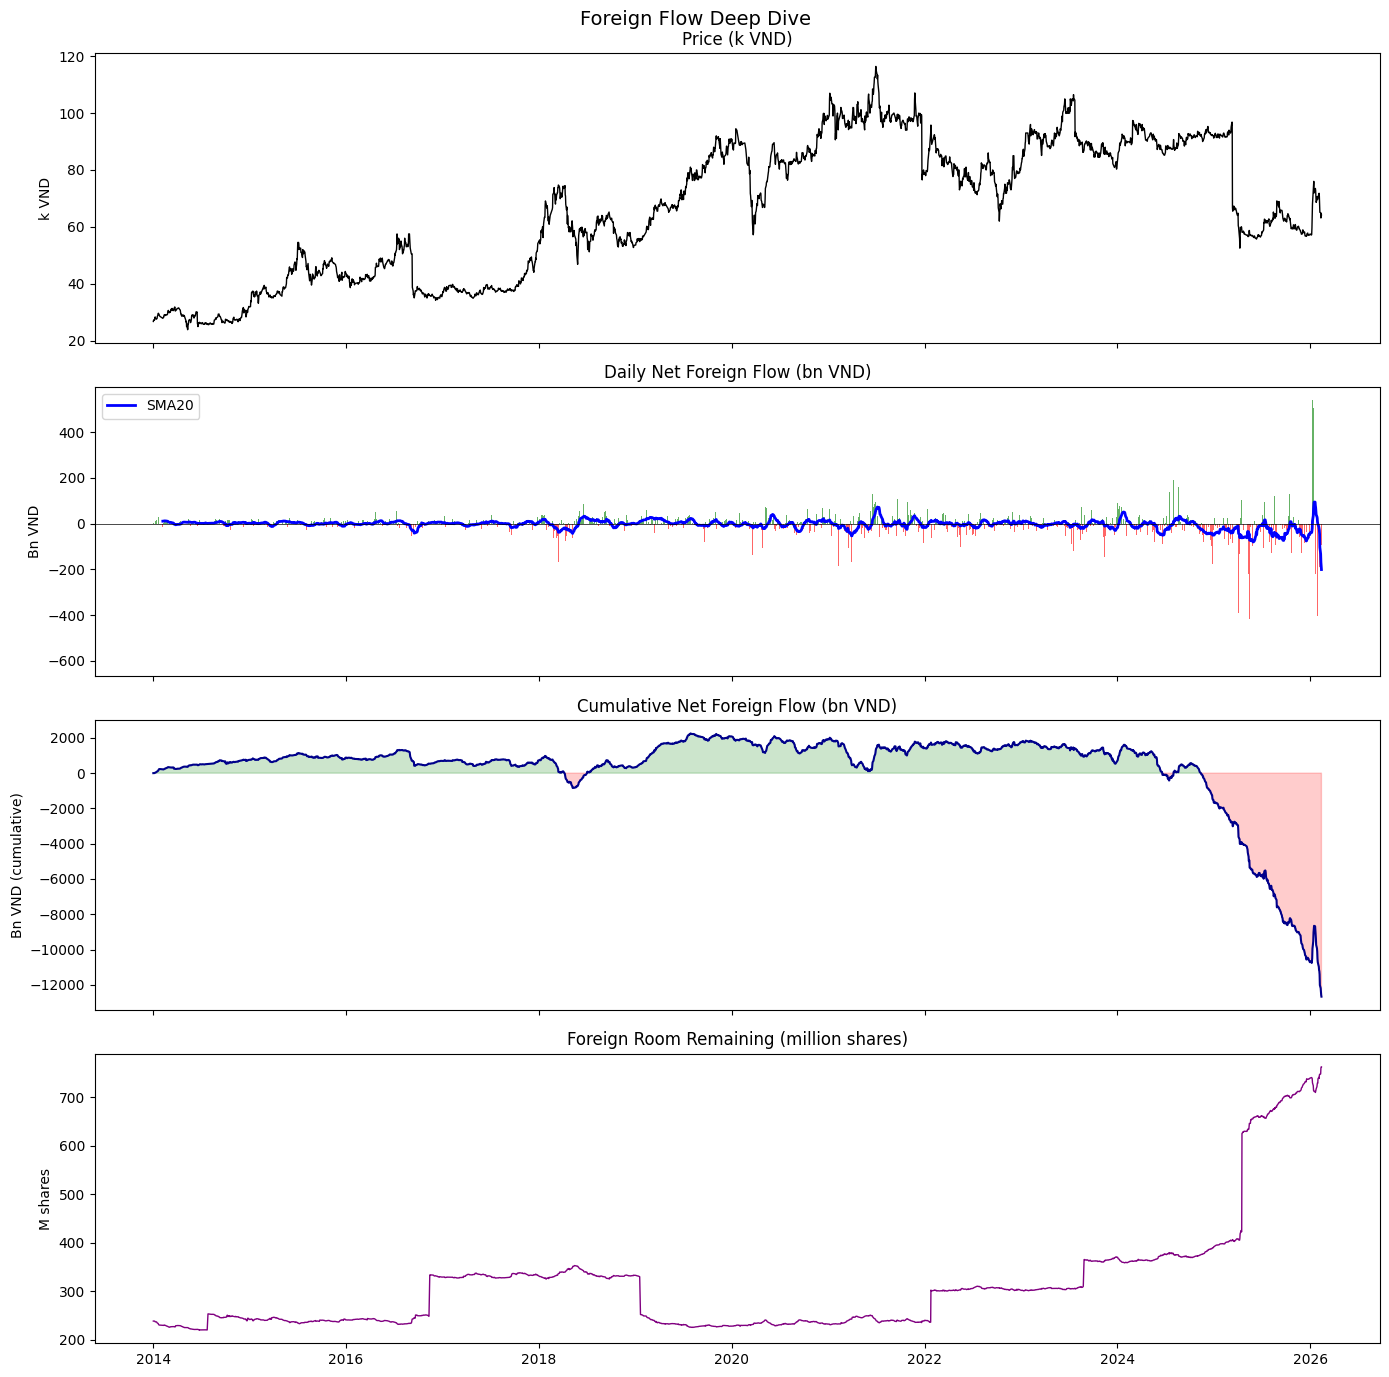

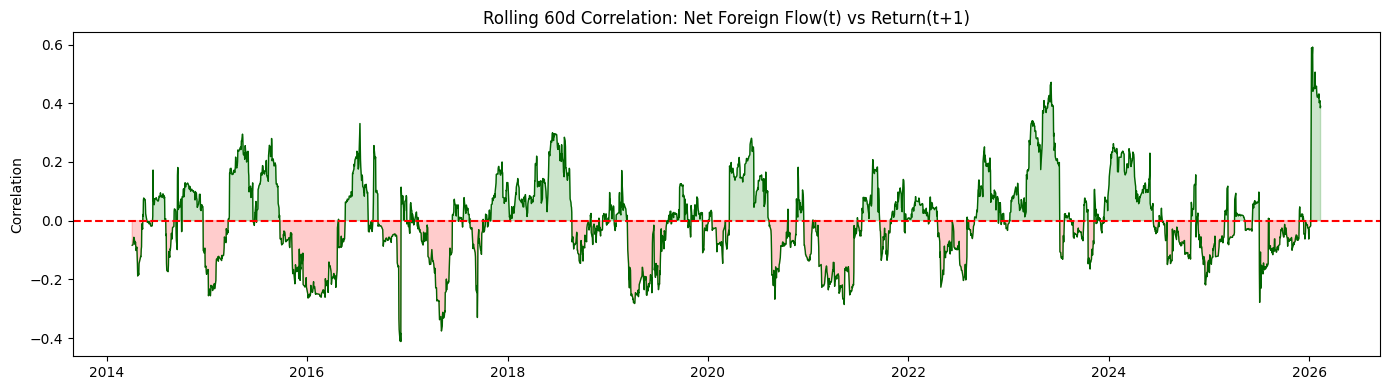


FOREIGN FLOW PREDICTIVE POWER
Mean rolling correlation (flow → next-day return): 0.0044
Median: -0.0006
% of days with positive correlation: 48.9%

Interpretation:
  → Positive corr = foreign flow has predictive power (buy today → price up tomorrow)
  → Negative corr = foreign flow is contrarian indicator
  → Near zero = no relationship


In [ ]:
analyze_rolling_volatility(vcb)
analyze_volume_microstructure(vcb)
analyze_foreign_flow(vcb)

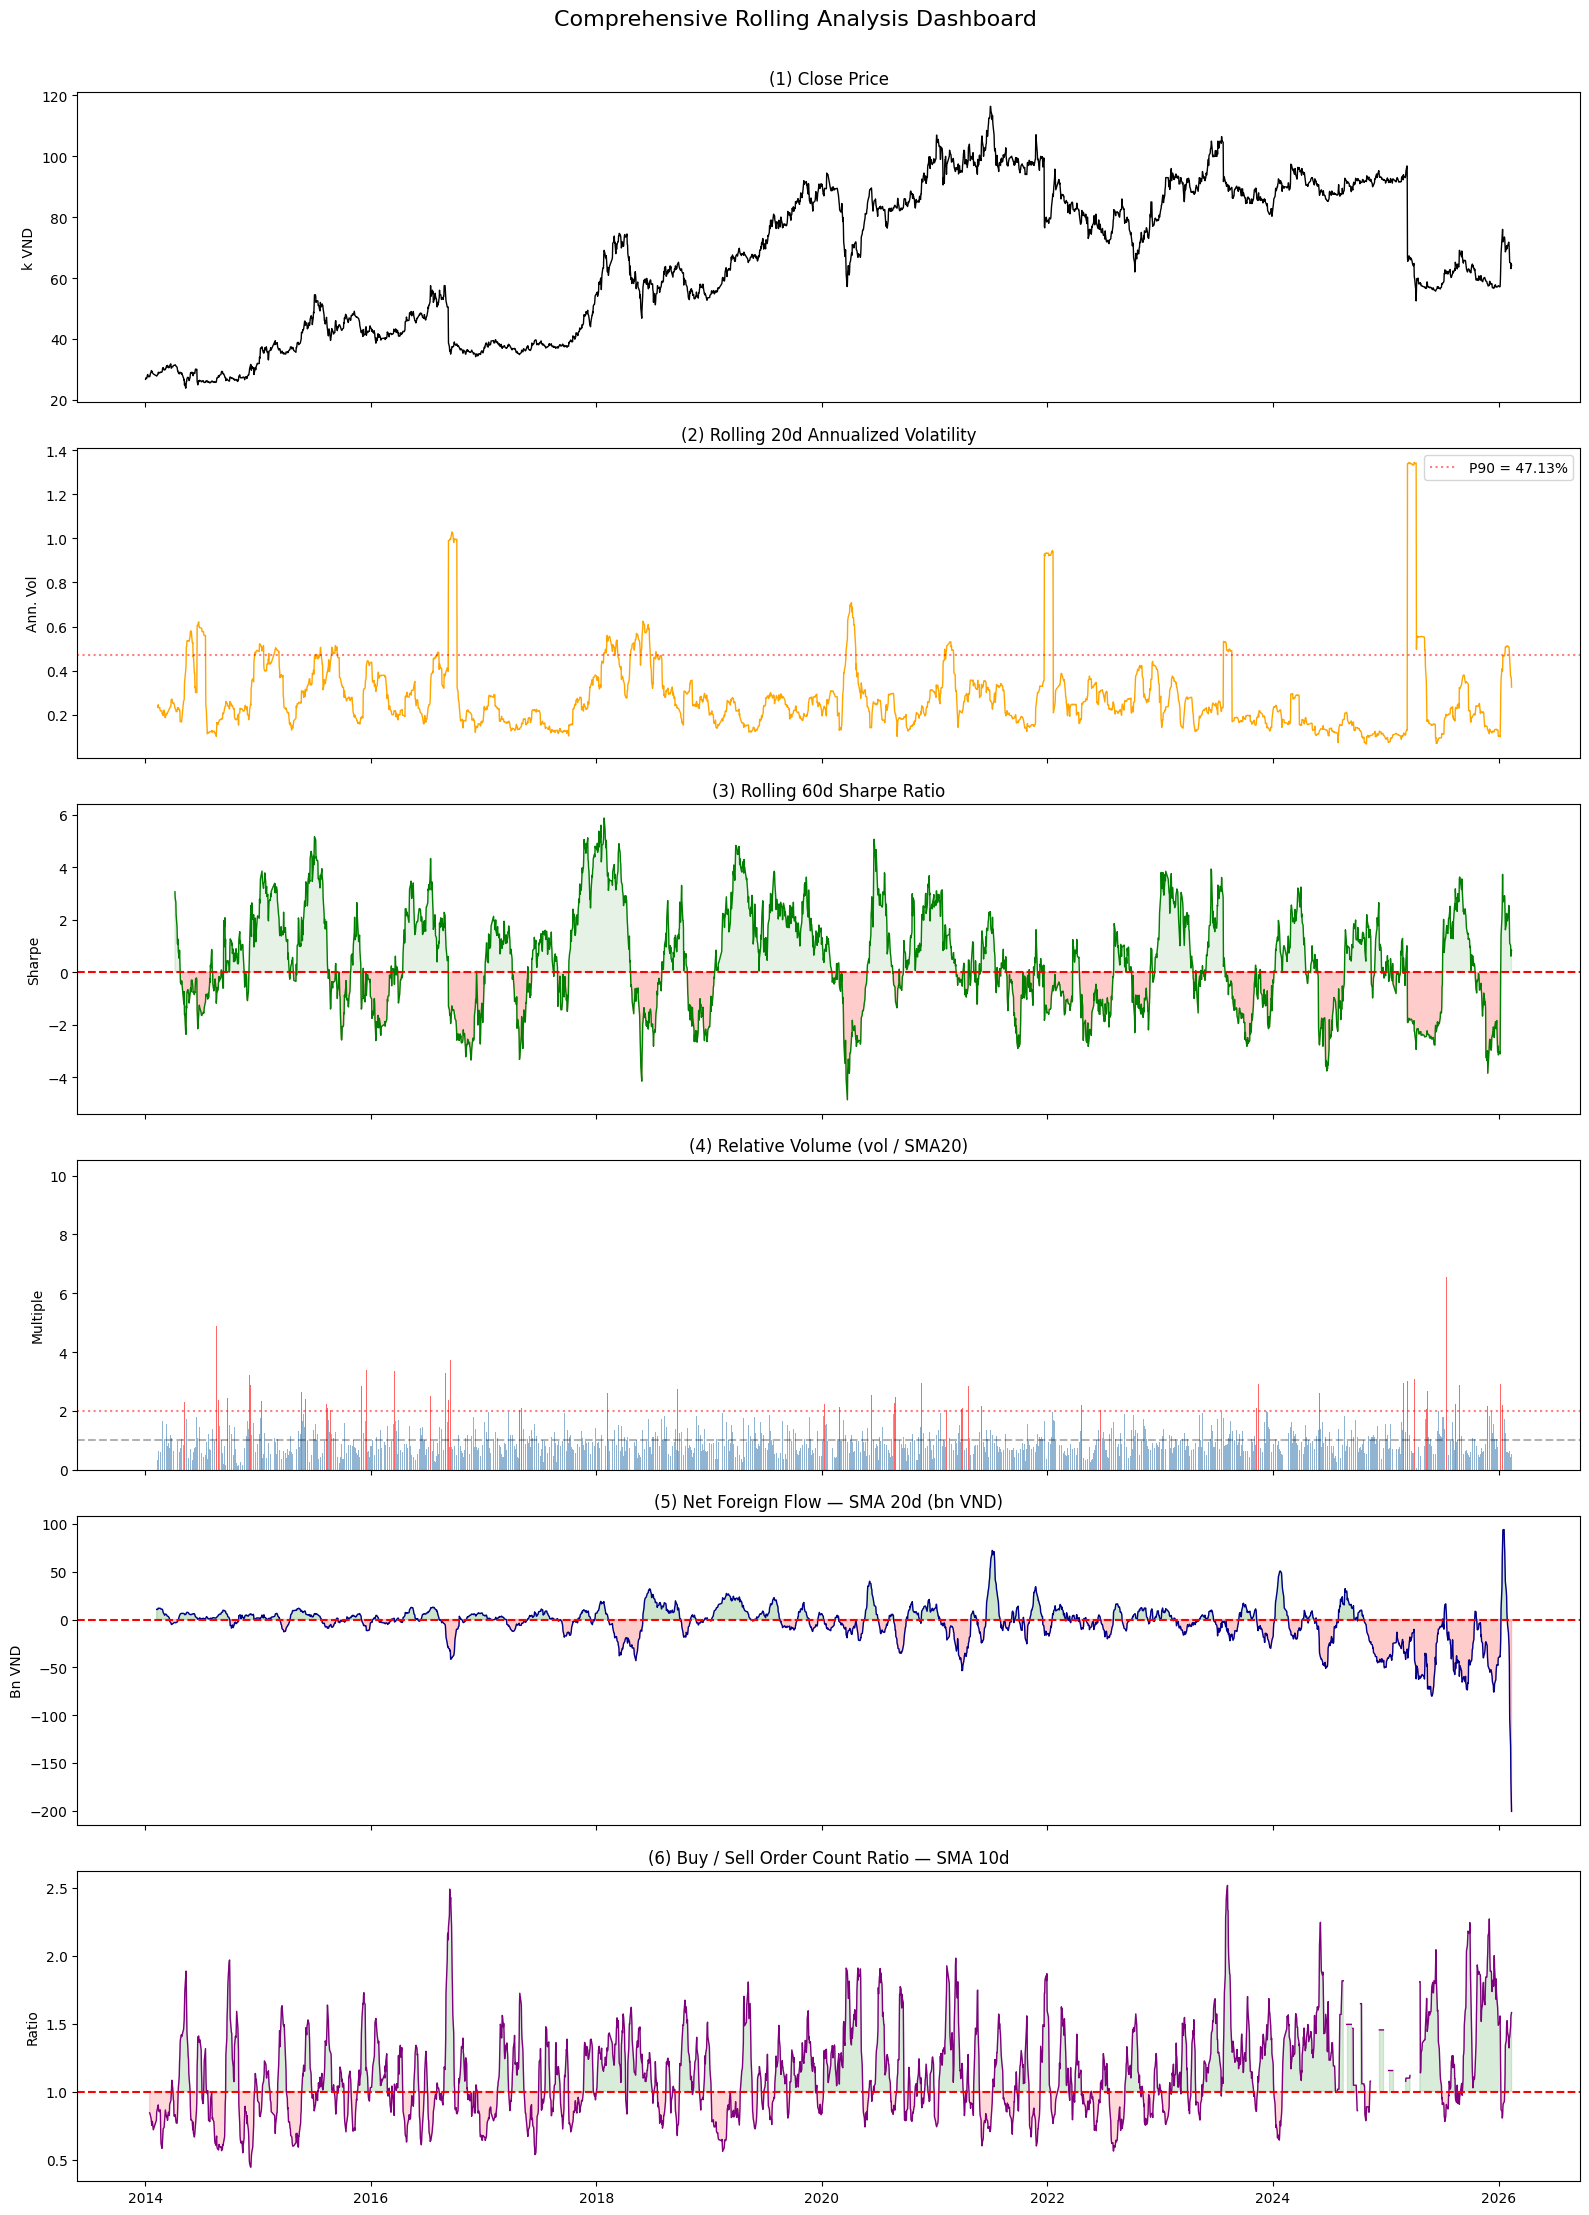

In [ ]:
create_comprehensive_dashboard(vcb)

In [ ]:
def compare_ewm_vs_rolling(df, rolling_window=40, ewm_halflife=20):
    """
    Direct comparison of EWM vs Rolling volatility.
    
    Uses approximately equivalent pairs: rolling(40d) ≈ EWM(halflife=20d)
    Shows when each responds faster and the ratio dynamics.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame from load_single_stock()
    rolling_window : int
        Rolling window size (default 40)
    ewm_halflife : int
        EWM halflife (default 20, approximately rolling_window/2)
    """
    ret = df['log_ret']

    # Calculate volatilities
    roll_vol = ret.rolling(rolling_window).std() * np.sqrt(252)
    ewm_vol = ret.ewm(halflife=ewm_halflife).std() * np.sqrt(252)

    fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    # Top: overlay comparison
    axes[0].plot(df.index, roll_vol, label=f'Rolling {rolling_window}d', alpha=0.8, linewidth=1)
    axes[0].plot(df.index, ewm_vol, label=f'EWM halflife={ewm_halflife}d', alpha=0.8, linewidth=1)
    axes[0].set_title(f'Rolling({rolling_window}d) vs EWM(halflife={ewm_halflife}d) — Annualized Volatility')
    axes[0].set_ylabel('Ann. Vol')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Bottom: ratio analysis
    ratio = ewm_vol / roll_vol
    axes[1].plot(df.index, ratio, color='purple', linewidth=1)
    axes[1].axhline(y=1, color='red', linestyle='--')
    axes[1].fill_between(df.index, 1, ratio, where=ratio > 1, alpha=0.2, color='orange',
                         label='EWM > Rolling')
    axes[1].fill_between(df.index, 1, ratio, where=ratio < 1, alpha=0.2, color='blue',
                         label='EWM < Rolling')
    axes[1].set_title('Ratio: EWM vol / Rolling vol')
    axes[1].set_ylabel('Ratio')
    axes[1].legend()

    plt.tight_layout()
    plt.savefig('ewm_vs_rolling.png', dpi=150)
    plt.show()

    # Statistics
    print("\n" + "="*70)
    print("EWM VS ROLLING COMPARISON")
    print("="*70)
    print(f"Mean ratio: {ratio.mean():.4f}")
    print(f"Ratio > 1 (EWM higher): {(ratio > 1).mean():.1%} of days")
    print(f"Max ratio: {ratio.max():.3f} on {ratio.idxmax().date()}")
    print(f"Min ratio: {ratio.min():.3f} on {ratio.idxmin().date()}")
    print("\nInterpretation:")
    print("  ratio > 1 right after shock: EWM reacts faster (spikes higher)")
    print("  ratio < 1 later: EWM decays faster (rolling still holds the shock)")

In [ ]:
def demonstrate_ghost_feature(df, rolling_window=20, ewm_halflife=10):
    """
    Demonstrate the ghost feature in rolling volatility.
    
    The ghost feature: rolling vol stays elevated for exactly k days after
    a shock, then drops ABRUPTLY when the shock exits the window.
    EWM decays smoothly without this artifact.
    
    Zooms into ±40 trading days around the largest shock.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame from load_single_stock()
    rolling_window : int
        Rolling window size (default 20)
    ewm_halflife : int
        EWM halflife (default 10)
    """
    ret = df['log_ret'].dropna()

    # Find the largest shock
    shock_day = ret.abs().idxmax()
    shock_ret = ret[shock_day]
    
    print("\n" + "="*70)
    print("GHOST FEATURE DEMONSTRATION")
    print("="*70)
    print(f"Largest shock: {shock_day.date()}, return = {shock_ret:.4f} ({shock_ret * 100:.2f}%)")

    # Compute volatilities on the FULL return series (not df)
    roll_vol = ret.rolling(rolling_window).std() * np.sqrt(252)
    ewm_vol = ret.ewm(halflife=ewm_halflife).std() * np.sqrt(252)

    # Create zoom window: ±60 calendar days around shock
    zoom_start = shock_day - pd.Timedelta(days=60)
    zoom_end = shock_day + pd.Timedelta(days=60)
    
    # Filter using ret.index (not df.index) to avoid length mismatch
    zoom_ret = ret[(ret.index >= zoom_start) & (ret.index <= zoom_end)]
    zoom_roll = roll_vol[(roll_vol.index >= zoom_start) & (roll_vol.index <= zoom_end)]
    zoom_ewm = ewm_vol[(ewm_vol.index >= zoom_start) & (ewm_vol.index <= zoom_end)]

    fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    # Top: returns around the shock
    colors = np.where(zoom_ret > 0, 'green', 'red')
    axes[0].bar(zoom_ret.index, zoom_ret * 100, color=colors, width=1, alpha=0.6)
    axes[0].axvline(x=shock_day, color='black', linestyle='--', linewidth=2, label='Shock day')
    axes[0].set_title(f'Returns around largest shock ({shock_day.date()})')
    axes[0].set_ylabel('Return (%)')
    axes[0].legend()

    # Bottom: rolling vs EWM vol
    axes[1].plot(zoom_roll.index, zoom_roll, label=f'Rolling {rolling_window}d', 
                 linewidth=2, color='blue')
    axes[1].plot(zoom_ewm.index, zoom_ewm, label=f'EWM halflife={ewm_halflife}d', 
                 linewidth=2, color='orange')
    axes[1].axvline(x=shock_day, color='black', linestyle='--', linewidth=2)

    # Mark the ghost exit: rolling_window trading days after shock
    trading_days_after = ret.index[ret.index > shock_day]
    if len(trading_days_after) >= rolling_window:
        ghost_exit = trading_days_after[rolling_window - 1]
        axes[1].axvline(x=ghost_exit, color='red', linestyle=':', linewidth=2,
                        label=f'Ghost exit ({ghost_exit.date()})')
        print(f"Ghost exit day ({rolling_window} trading days later): {ghost_exit.date()}")

    axes[1].set_title('Rolling vs EWM Volatility — Ghost Feature Demo')
    axes[1].set_ylabel('Ann. Vol')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('ghost_feature.png', dpi=150)
    plt.show()

    print("\nWhat to observe:")
    print(f"  - Rolling {rolling_window}d: vol jumps up → stays FLAT for ~{rolling_window} days → drops ABRUPTLY")
    print(f"  - EWM hl={ewm_halflife}:  vol jumps up → decays SMOOTHLY → more natural")
    print("  - The abrupt drop in rolling vol is the 'ghost feature'")
    print("  - It's an artifact of the rectangular kernel, not real market behavior")

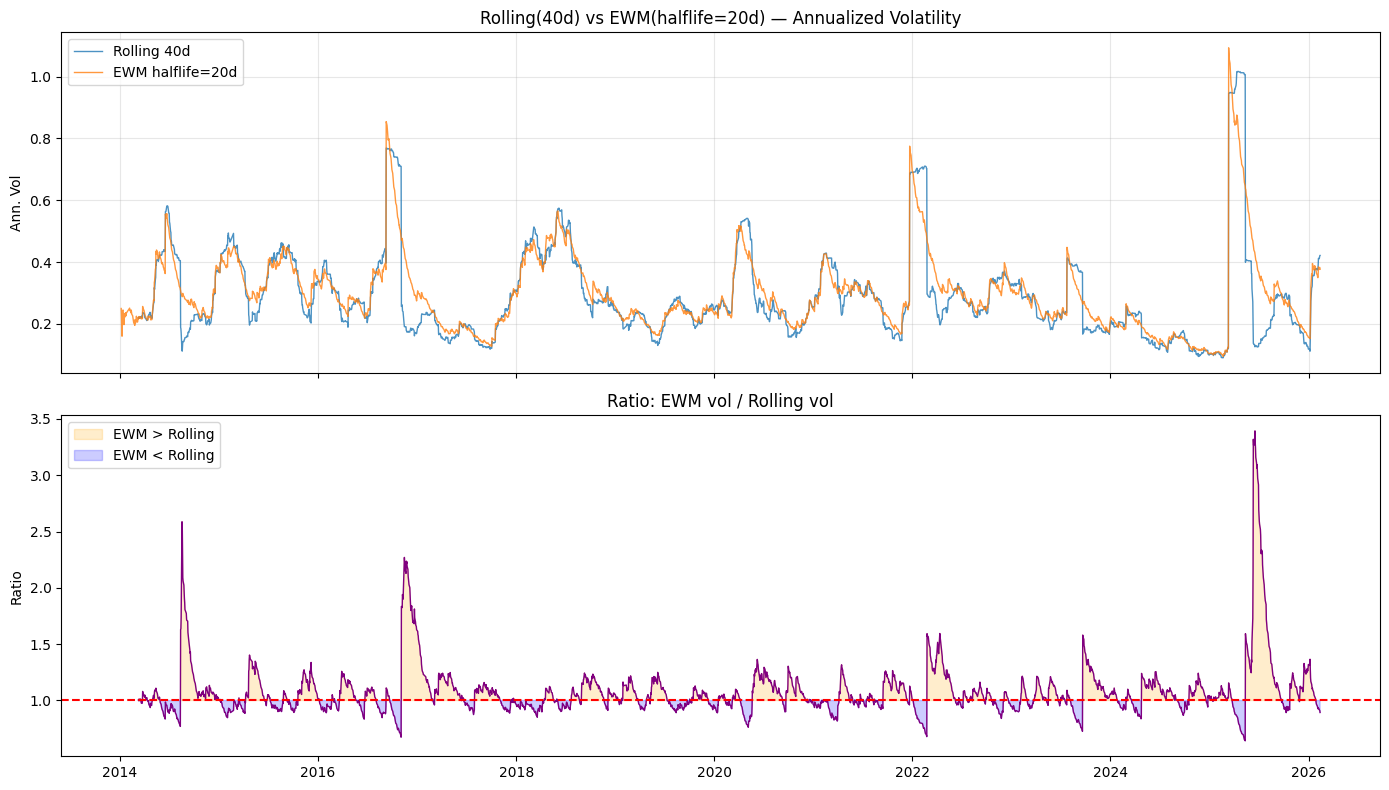


EWM VS ROLLING COMPARISON
Mean ratio: 1.0838
Ratio > 1 (EWM higher): 60.6% of days
Max ratio: 3.393 on 2025-06-17
Min ratio: 0.642 on 2025-05-12

Interpretation:
  ratio > 1 right after shock: EWM reacts faster (spikes higher)
  ratio < 1 later: EWM decays faster (rolling still holds the shock)


In [ ]:
compare_ewm_vs_rolling(vcb)


GHOST FEATURE DEMONSTRATION
Largest shock: 2025-03-12, return = -0.3724 (-37.24%)
Ghost exit day (20 trading days later): 2025-04-10


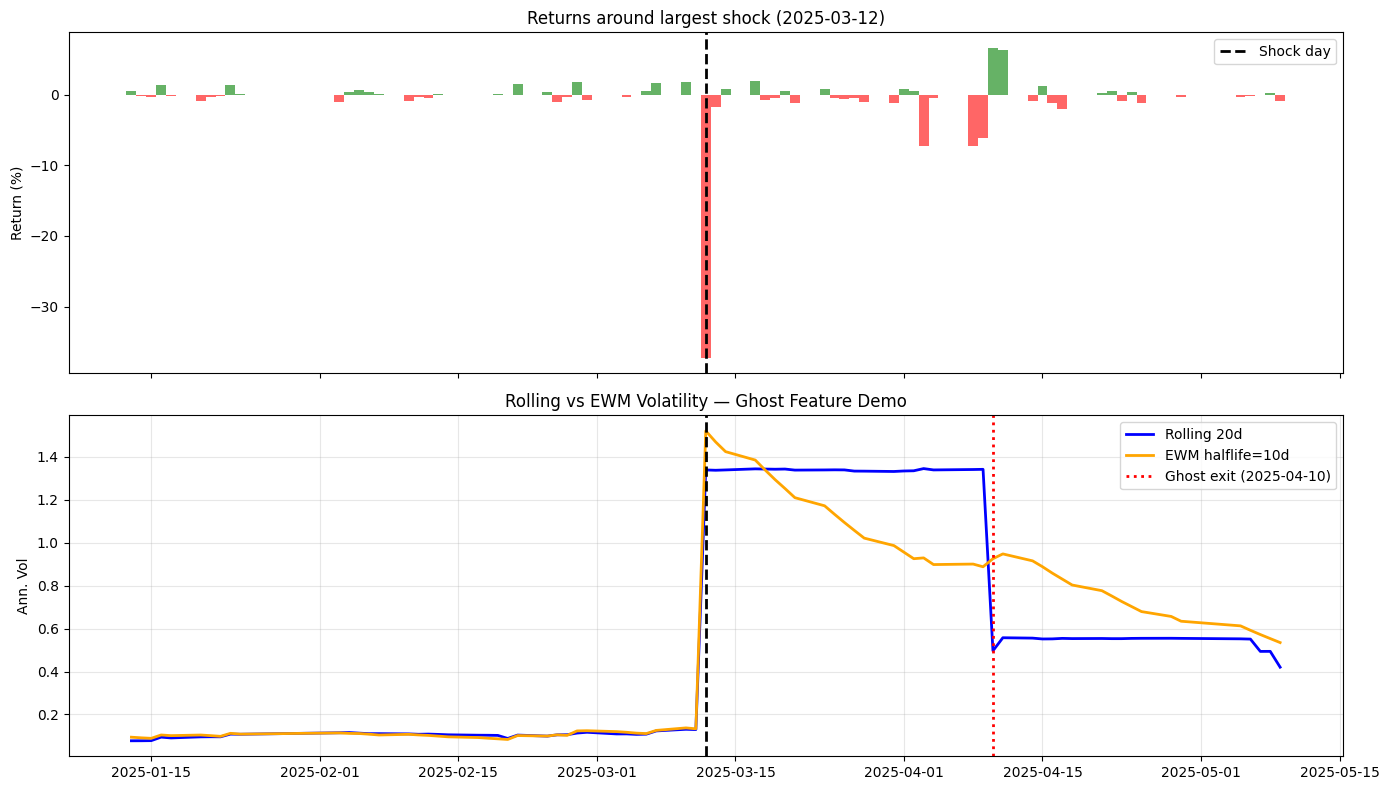


What to observe:
  - Rolling 20d: vol jumps up → stays FLAT for ~20 days → drops ABRUPTLY
  - EWM hl=10:  vol jumps up → decays SMOOTHLY → more natural
  - The abrupt drop in rolling vol is the 'ghost feature'
  - It's an artifact of the rectangular kernel, not real market behavior


In [ ]:
demonstrate_ghost_feature(vcb)

In [ ]:
def analyze_ewm_foreign_flow(df, sma_window=20, ewm_halflife=10):
    """
    Apply EWM to foreign flow signal smoothing.
    
    Compare SMA vs EWM for smoothing net foreign flow.
    EWM responds faster when flow direction reverses.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame from load_single_stock()
    sma_window : int
        Simple moving average window (default 20)
    ewm_halflife : int
        EWM halflife (default 10)
    """
    fgn = df['fgn_net_val'] / 1e9  # convert to billion VND

    sma = fgn.rolling(sma_window).mean()
    ewm = fgn.ewm(halflife=ewm_halflife).mean()

    fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    # Top: Price context
    axes[0].plot(df.index, df['close'] / 1000, 'k-', linewidth=1)
    axes[0].set_title('Price (k VND)')
    axes[0].set_ylabel('k VND')

    # Bottom: Foreign flow with smoothers
    axes[1].bar(df.index, fgn, color='gray', alpha=0.3, width=1, label='Daily net flow')
    axes[1].plot(df.index, sma, label=f'SMA {sma_window}d', linewidth=2, color='blue')
    axes[1].plot(df.index, ewm, label=f'EWM halflife={ewm_halflife}d', linewidth=2, color='orange')
    axes[1].axhline(y=0, color='red', linestyle='--')
    axes[1].set_title('Foreign Flow Smoothing: SMA vs EWM')
    axes[1].set_ylabel('Bn VND')
    axes[1].legend()

    plt.tight_layout()
    plt.savefig('ewm_foreign_flow.png', dpi=150)
    plt.show()

    # Count zero-crossings (signal changes)
    sma_crosses = ((sma > 0).astype(int).diff().abs() > 0).sum()
    ewm_crosses = ((ewm > 0).astype(int).diff().abs() > 0).sum()
    
    print("\n" + "="*70)
    print("FOREIGN FLOW SMOOTHING ANALYSIS")
    print("="*70)
    print(f"Zero-crossings (flow direction changes):")
    print(f"  SMA {sma_window}d: {sma_crosses} times")
    print(f"  EWM hl={ewm_halflife}d: {ewm_crosses} times")
    print(f"\nEWM crosses more often → more responsive to flow reversals")
    print(f"But also more false signals. Same tradeoff as volatility estimation.")

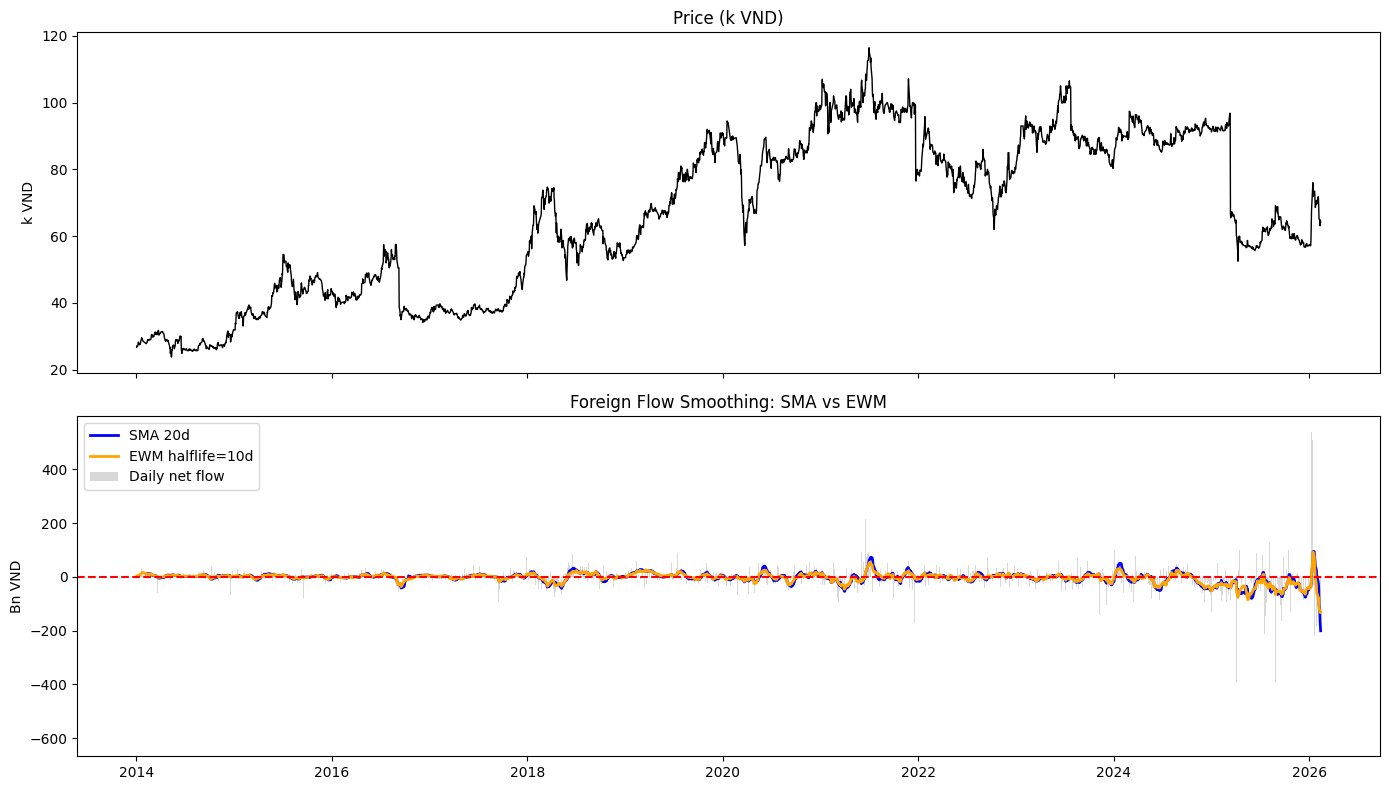


FOREIGN FLOW SMOOTHING ANALYSIS
Zero-crossings (flow direction changes):
  SMA 20d: 144 times
  EWM hl=10d: 145 times

EWM crosses more often → more responsive to flow reversals
But also more false signals. Same tradeoff as volatility estimation.


In [ ]:
analyze_ewm_foreign_flow(vcb)